# Random Feature for Gaussian Kernel
Gaussian Kernel 정의: $k(\mathbf{x}, \mathbf{y}) = \exp(-\frac{\|\mathbf{x}-\mathbf{y}\|^2}{2})$  
$\mathbf{x}$와 $\mathbf{y}$가 평행이동하더라도 커널값이 변하지 않으므로 shift-invariant kernel이다.


[[1.         0.08865319 0.17984223 0.98174488]
 [0.08865319 1.         0.17804411 0.07194706]
 [0.17984223 0.17804411 1.         0.20742471]
 [0.98174488 0.07194706 0.20742471 1.        ]]


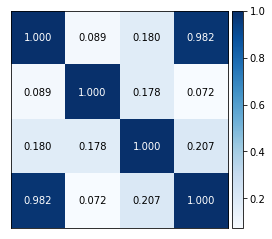

In [115]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
np.random.seed(1)

# d차원 공간 상의 n개의 점을 랜덤하게 생성한다.
n, d = 4, 2
x = np.random.randn(4, 2) + 0.5

# 벡터의 차를 계산하고 모든 벡터 페어의 가우시안 커널 값을 계산한다.
delta = x[:, None, :] - x[None, :, :]
kernel = np.exp(-np.einsum("ijk,ijk->ij", delta, delta) / 2)
print(kernel)

# 시각화
fig, ax = plt.subplots()
ax.set_xticks([])
ax.set_yticks([])
im = ax.imshow(kernel, cmap=plt.get_cmap("Blues"))
for j in range(kernel.shape[0]):
    for i in range(kernel.shape[1]):
        ax.text(j, i, f"{kernel[j, i]:.3f}", ha="center", va="center", c="w" if kernel[j, i] > 0.5 else "k")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.show()

## Feature function for Gaussian kernel
가우시안 커널은 symmetric하며 positive definiteness임이 알려져있다.  
이는 적절한 피쳐 함수 $\phi$가 있어 이 함수를 통해 나온 피쳐 간의 내적가 커널값과 같음을 의미한다.
$$k(\mathbf{x}, \mathbf{y}) = \phi(\mathbf{x})^\top \phi(\mathbf{y})$$
보통, $\phi$를 통해 나온 피쳐의 차원은 무한 차원이 될 수 있으며 이는 커널이 무한 차원의 피쳐를 표현할 수 있게 한다는 장점을 드러내는데 사용되기도 한다.  
우리는 여기서 적절한 수준의 피쳐 함수 $\mathbf{z}$를 설정하는데 이 함수의 내적값이 커널값을 근사하게끔 만든다.
$$k(\mathbf{x}, \mathbf{y}) \approx \mathbf{z}(\mathbf{x})^\top \mathbf{z}(\mathbf{y})$$

## Random feature function
피쳐 함수를 설정하는 방법 가운데 하나는 랜덤한 피쳐를 이용하는 것이다.
$$\mathbf{z}(\mathbf{x}) = f(\mathbf{w}^\top\mathbf{x}) \text{ such that } \mathbf{w} \sim p(\mathbf{w})$$
아직은 $p(\mathbf{w})$을 어떻게 설정할 수 있는 건지 잘 모르겠지만 논문에서는 $p(\mathbf{w}) = \mathcal{N}(\mathbf{0},\mathbf{I}_d)$를 사용하면 근사 오류에 어떤 bound가 형성된다고 하는 것 같다.  
여러 논문마다 피쳐가 다르긴 한데 삼각함수 2개를 사용하는 것이 분산을 줄여주기 때문에 더 잘 사용되는 것 같다.
$$\mathbf{z}_1(\mathbf{x}) = [ \cos(\mathbf{w}_1^\top\mathbf{x}), \sin (\mathbf{w}_1^\top \mathbf{x}) ] \text{ such that } \mathbf{w}_1 \sim \mathcal{N}(\mathbf{0},\mathbf{I}_d)$$

error mean: 0.411, variance: 0.018


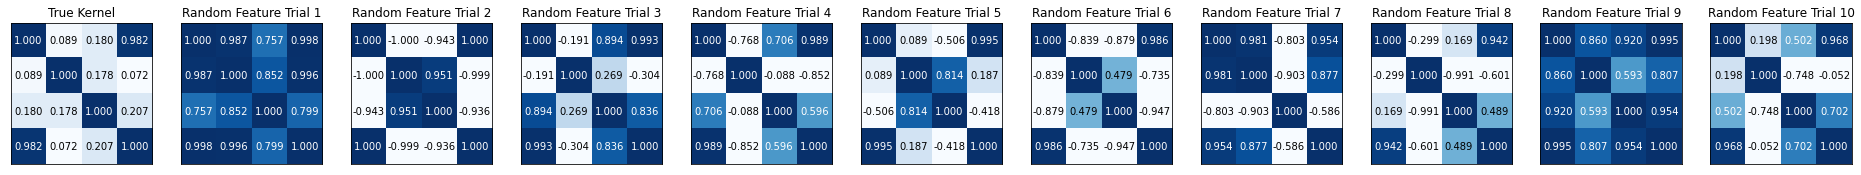

In [137]:
kernel_rf_list = []
error_list = []
for _ in range(10):
    w = np.random.multivariate_normal(mean=np.zeros(d), cov=np.eye(d), size=(1,))
    wx = np.einsum("nd,kd->nk", x, w)
    z = np.concatenate((np.cos(wx), np.sin(wx)), axis=1)
    kernel_rf = np.einsum("nk,mk->nm", z, z)
    kernel_rf_list.append(kernel_rf)
    error = np.mean(np.abs(kernel - kernel_rf))
    error_list.append(error)
print(f"error mean: {np.mean(error_list):.3f}, variance: {np.var(error_list):.3f}")

# 시각화
fig, axes = plt.subplots(1, 11, figsize=(33, 3), facecolor="w")
for idx in range(11):
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

axes[0].set_title("True Kernel")
im = axes[0].imshow(kernel, cmap=plt.get_cmap("Blues"))
for j in range(kernel.shape[0]):
    for i in range(kernel.shape[1]):
        axes[0].text(j, i, f"{kernel[j, i]:.3f}", ha="center", va="center", c="w" if kernel[j, i] > 0.5 else "k")
for idx in range(1, 11):
    axes[idx].set_title(f"Random Feature Trial {idx}")
    im = axes[idx].imshow(kernel_rf_list[idx-1], cmap=plt.get_cmap("Blues"), vmin=0, vmax=1)
    for j in range(kernel_rf_list[idx-1].shape[0]):
        for i in range(kernel_rf_list[idx-1].shape[1]):
            axes[idx].text(j, i, f"{kernel_rf_list[idx-1][j, i]:.3f}", ha="center", va="center", c="w" if kernel_rf_list[idx-1][j, i] > 0.5 else "k")
plt.show()

보다시피 하나의 랜덤 벡터만 사용하는 것은 근사 오류가 크기 때문에 이를 줄이기 위해 여러 랜덤 벡터로 구한 뒤 평균을 낸다.
$$\mathbf{z}_2(\mathbf{x}) = \frac{1}{\sqrt{m}} [ \cos(\mathbf{w}_1^\top\mathbf{x}), \sin (\mathbf{w}_1^\top \mathbf{x}), ..., \cos(\mathbf{w}_m^\top\mathbf{x}), \sin (\mathbf{w}_m^\top \mathbf{x}) ] \text{ such that } \mathbf{w}_1, ..., \mathbf{w}_m \sim \mathcal{N}(\mathbf{0},\mathbf{I}_d)$$
열 개의 랜덤 벡터를 쓰면 확 좋아지는 걸 볼 수 있다.

error mean: 0.102, variance: 0.003


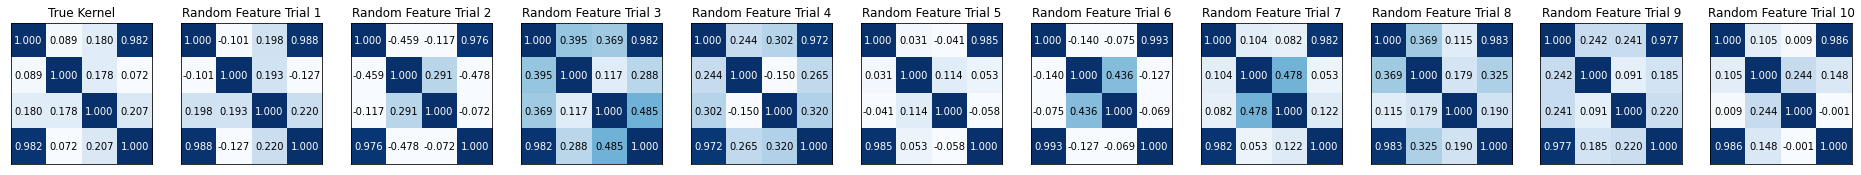

In [ ]:
m = 10
kernel_rf_list = []
error_list = []
for _ in range(10):
    w = np.random.multivariate_normal(mean=np.zeros(d), cov=np.eye(d), size=(m,))
    wx = np.einsum("nd,kd->nk", x, w)
    z = np.concatenate((np.cos(wx), np.sin(wx)), axis=1)
    z = z / np.sqrt(m)
    kernel_rf = np.einsum("nk,mk->nm", z, z)
    kernel_rf_list.append(kernel_rf)
    error = np.mean(np.abs(kernel - kernel_rf))
    error_list.append(error)
print(f"error mean: {np.mean(error_list):.3f}, variance: {np.var(error_list):.3f}")

# 시각화
fig, axes = plt.subplots(1, 11, figsize=(33, 3), facecolor="w")
for idx in range(11):
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

axes[0].set_title("True Kernel")
im = axes[0].imshow(kernel, cmap=plt.get_cmap("Blues"))
for j in range(kernel.shape[0]):
    for i in range(kernel.shape[1]):
        axes[0].text(j, i, f"{kernel[j, i]:.3f}", ha="center", va="center", c="w" if kernel[j, i] > 0.5 else "k")
for idx in range(1, 11):
    axes[idx].set_title(f"Random Feature Trial {idx}")
    im = axes[idx].imshow(kernel_rf_list[idx-1], cmap=plt.get_cmap("Blues"), vmin=0, vmax=1)
    for j in range(kernel_rf_list[idx-1].shape[0]):
        for i in range(kernel_rf_list[idx-1].shape[1]):
            axes[idx].text(j, i, f"{kernel_rf_list[idx-1][j, i]:.3f}", ha="center", va="center", c="w" if kernel_rf_list[idx-1][j, i] > 0.5 else "k")
plt.show()